In [1]:
import os

# Use the eager mode
os.environ['PT_HPU_LAZY_MODE'] = '0'

# Verify the environment variable is set
print(f"PT_HPU_LAZY_MODE: {os.environ['PT_HPU_LAZY_MODE']}")

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import habana_frameworks.torch.core as htcore

PT_HPU_LAZY_MODE: 0


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)


2.4.0a0+git74cd574


/usr/lib/python3.10/inspect.py:288: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(object, types.FunctionType)


In [2]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

In [3]:
device_hpu = torch.device("hpu")
device_cpu = torch.device("cpu")

Epoch 1, Loss: 4.7024
Epoch 2, Loss: 4.6033
Epoch 3, Loss: 4.7485
Epoch 4, Loss: 4.5086
Epoch 5, Loss: 4.5393
Epoch 6, Loss: 4.4591
Epoch 7, Loss: 4.4086
Epoch 8, Loss: 4.3774
Epoch 9, Loss: 4.2952
Epoch 10, Loss: 4.2503


============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 0
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2113407800 KB
------------------------------------------------------------------------------


Epoch 1, Loss: 4.7017
Epoch 2, Loss: 4.6940
Epoch 3, Loss: 4.7663
Epoch 4, Loss: 4.6688
Epoch 5, Loss: 4.6693
Epoch 6, Loss: 4.7181
Epoch 7, Loss: 4.6356
Epoch 8, Loss: 4.6326
Epoch 9, Loss: 4.6306
Epoch 10, Loss: 4.6158


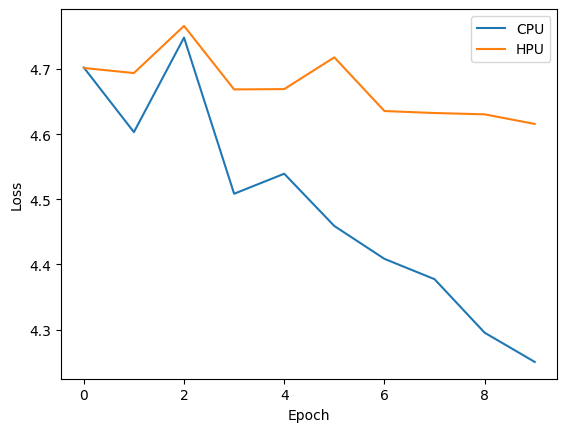

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setup
vocab_size = 1000
embedding_dim = 32
num_negatives = 5
batch_size = 64
num_epochs = 10

# Model
class SimpleEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        return self.embedding(x)

# Training data - simple co-occurrence pairs
def generate_batch(batch_size, vocab_size, num_negatives):
    # Positive pairs
    target = torch.randint(0, vocab_size, (batch_size,))
    context = torch.randint(0, vocab_size, (batch_size,))
    
    # Negative samples
    negatives = torch.randint(0, vocab_size, (batch_size, num_negatives))
    
    return target, context, negatives

# Training loop
def train_embeddings(device):
    model = SimpleEmbedding(vocab_size, embedding_dim).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCEWithLogitsLoss()
    
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 100
        
        for _ in range(num_batches):
            target, context, negatives = generate_batch(batch_size, vocab_size, num_negatives)
            target, context, negatives = target.to(device), context.to(device), negatives.to(device)
            
            # Positive pairs
            pos_score = (model(target) * model(context)).sum(dim=1)
            pos_loss = criterion(pos_score, torch.ones_like(pos_score))
            
            # Negative pairs
            neg_score = (model(target).unsqueeze(1) * model(negatives)).sum(dim=2)
            neg_loss = criterion(neg_score, torch.zeros_like(neg_score))
            
            loss = pos_loss + neg_loss.mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        losses.append(epoch_loss / num_batches)
        print(f'Epoch {epoch+1}, Loss: {losses[-1]:.4f}')
    
    return model, losses

# Train on CPU
model_cpu, losses_cpu = train_embeddings(device_cpu)

# Train on HPU
model_hpu, losses_hpu = train_embeddings(device_hpu)

# Plot training curves
plt.plot(losses_cpu, label='CPU')
plt.plot(losses_hpu, label='HPU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()